# NLP - Personality Analysis
## Question 1
We want to explore the general trend of the conversation data. For this purpose, create a dataframe for each speaker by gathering all his utterances in a single file. Then write a script that determines the vocabulary set, vocabulary size, total number of tokens, total number of repetitions of words in the same post, total number of confirmation words (e.g., yes, OK, sure), total number of negation tokens, associated to each speaker. Summarize the result in a table, and then draw a subgraph that shows on the same plot the evolution of number of repetitions, number of negation, number of confirmation-like tokens, with respect to the number of tokens employed for each speaker (You may create some subdivision from the total number of tokens to ensure enough datum are used to represent the graphical illustration). Calculate the overall personality for each speaker by averaging over all instances of the original dataset, and comment on possible similarities and differences between speakers and whether some attributes are more associated with some personality patterns.

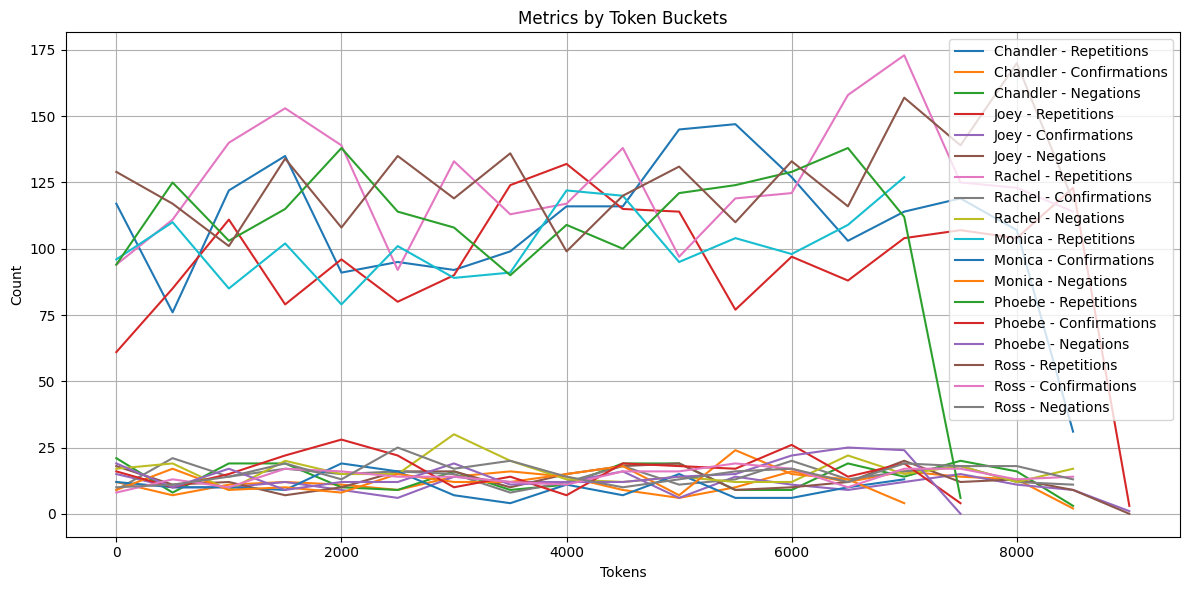

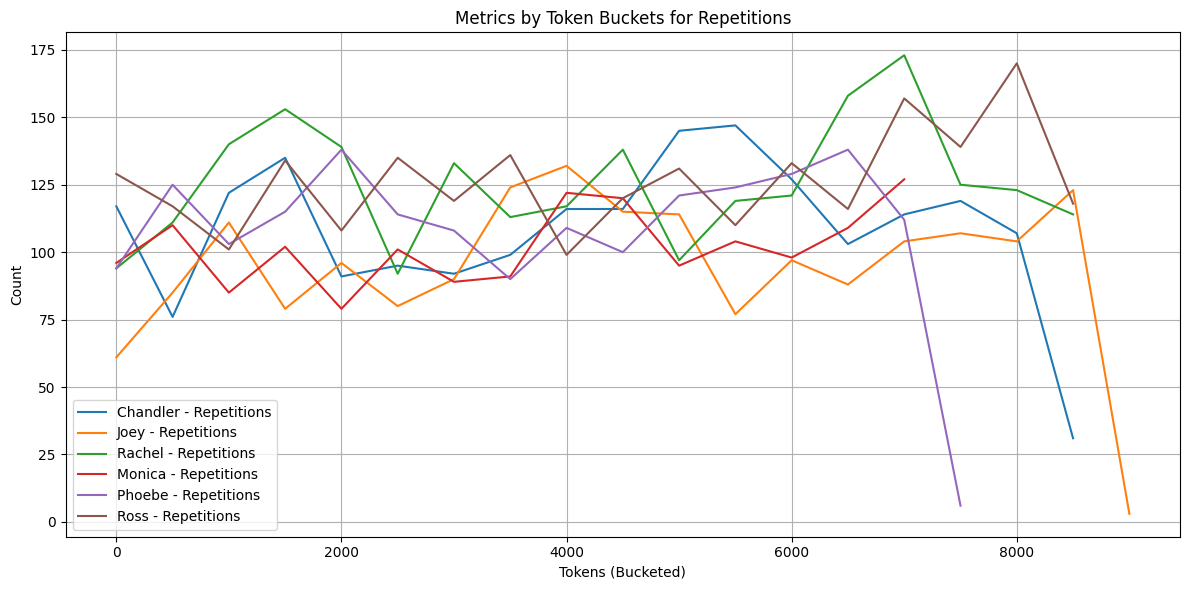

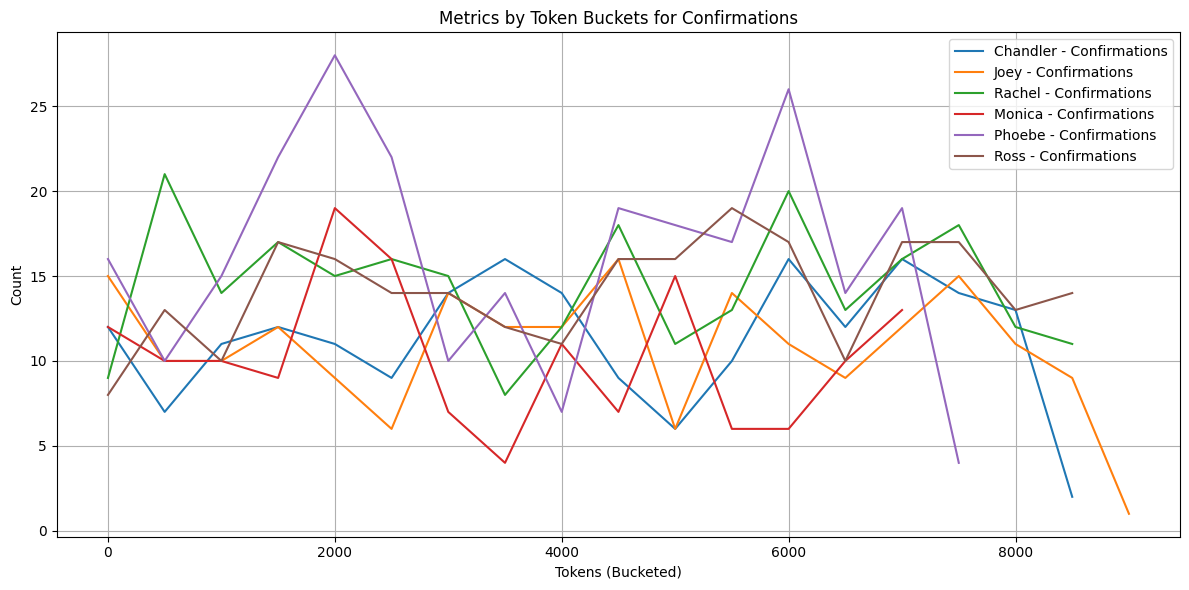

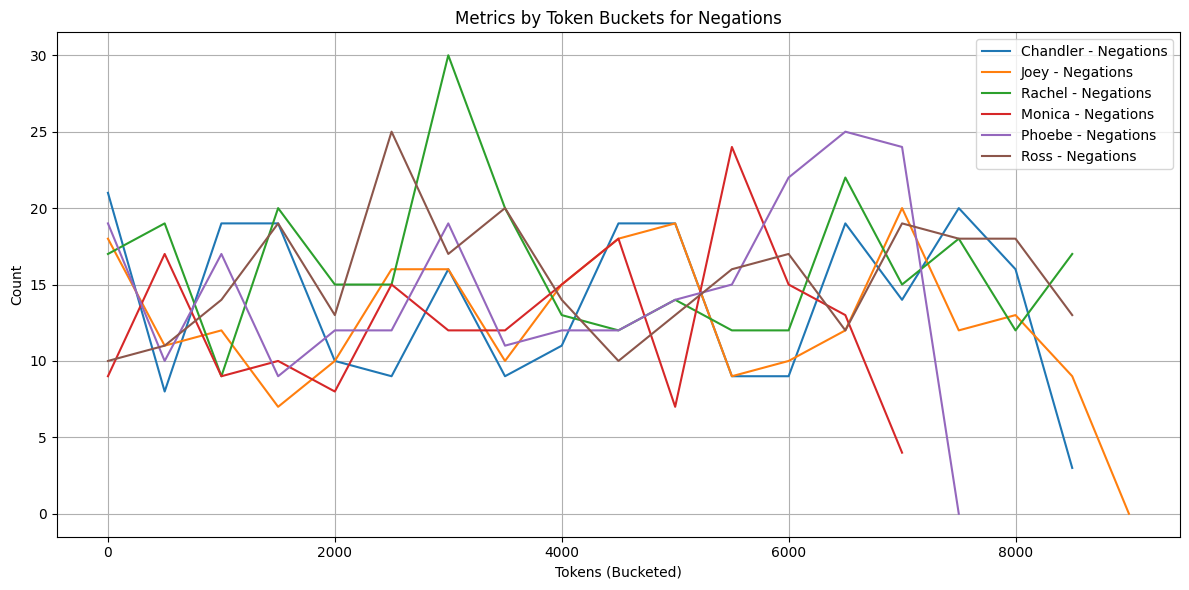

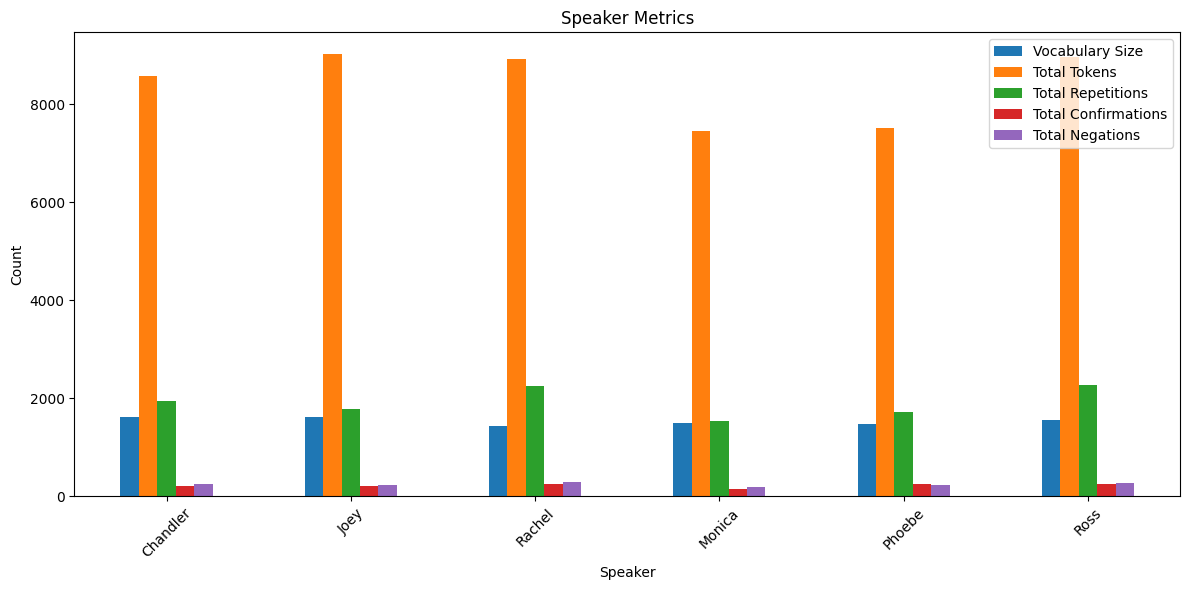

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np
import ast

# Define your words sets
confirmation_words = {'ok', 'yes', 'yeah', 'yep', 'okay', 'alright', 'sure', 'absolutely', 'certainly', 'of course', 'indeed', 'definitely'}
negation_words = {'no', 'not', 'never', 'none', 'nor', 'nobody', 'neither',
                  "don't", "isn't", "wasn't", "weren't", "doesn't", "won't", "haven't",
                  "don", "isn", "wasn", "weren", "doesn", "won", "haven",
                  "dont", "isnt", "wasnt", "werent", "doesnt", "wont", "havent"}
stop_words = {'the', 't', 's', 'a', 'to', 'is', 'and'}


def preprocess(sentence):
    tokens = sentence.split()
    return [
        token.translate(str.maketrans('', '', string.punctuation)).lower()
        for token in tokens if token not in stop_words
    ]


def calculate_row_metrics(speaker_df):
    speaker_df['Tokens'] = None
    speaker_df['Repetitions'] = None
    speaker_df['Confirmations'] = None
    speaker_df['Negations'] = None

    # Metrics per row
    for index, row in speaker_df.iterrows():
        tokens = preprocess(row['Utterance_1'])
        word_counts = Counter(tokens)

        confirmation_count = sum(count for word, count in word_counts.items() if word in confirmation_words)
        negation_count = sum(count for word, count in word_counts.items() if word in negation_words)

        U1_3_tokens = preprocess(row['Utterance_1'] + ' ' + row['Utterance_3'])
        U1_3_word_counts = Counter(U1_3_tokens)
        repetition_count = sum(count - 1 for word, count in U1_3_word_counts.items() if count > 1)
                
        # Assign calculated values to corresponding columns
        speaker_df.at[index, 'Tokens'] = tokens
        speaker_df.at[index, 'Repetitions'] = repetition_count
        speaker_df.at[index, 'Confirmations'] = confirmation_count
        speaker_df.at[index, 'Negations'] = negation_count

    return speaker_df


def calculate_overall_metrics(speaker_df):

    tokens = [token for sublist in speaker_df['Tokens'].values for token in sublist]
    total_tokens = len(tokens)
    
    vocabulary_set = set(tokens)
    vocabulary_size = len(vocabulary_set)

    total_repetitions = sum(speaker_df['Repetitions'].values)
    total_confirmations = sum(speaker_df['Confirmations'].values)
    total_negations = sum(speaker_df['Negations'].values)
    
    metrics = {}
    metrics['Vocabulary Size'] = vocabulary_size
    metrics['Total Tokens'] = total_tokens
    metrics['Total Repetitions'] = total_repetitions
    metrics['Total Confirmations'] = total_confirmations
    metrics['Total Negations'] = total_negations
    
    return metrics


def calculate_bucket_metrics(speaker_df, bucket_size=500):
    # Cumulative token counter
    cumulative_tokens = 0
    bucket_metrics = {
        'Bucket': [],
        'Repetitions': [],
        'Confirmations': [],
        'Negations': []
    }
    
    current_bucket = 0
    bucket_repetitions = 0
    bucket_confirmations = 0
    bucket_negations = 0

    for _, row in speaker_df.iterrows():
        # Get counts for this utterance
        token_size = len(row['Tokens'])
        cumulative_tokens += token_size

        # If we're in the same bucket, keep adding
        while cumulative_tokens > (current_bucket + 1) * bucket_size:
            # Save current bucket metrics
            bucket_metrics['Bucket'].append(current_bucket * bucket_size)
            bucket_metrics['Repetitions'].append(bucket_repetitions)
            bucket_metrics['Confirmations'].append(bucket_confirmations)
            bucket_metrics['Negations'].append(bucket_negations)
            
            # Reset metrics for the next bucket
            current_bucket += 1
            bucket_repetitions = 0
            bucket_confirmations = 0
            bucket_negations = 0

        # Add current row metrics to current bucket
        bucket_repetitions += row['Repetitions']
        bucket_confirmations += row['Confirmations']
        bucket_negations += row['Negations']

    # Add last bucket if not empty
    if bucket_repetitions > 0 or bucket_confirmations > 0 or bucket_negations > 0:
        bucket_metrics['Bucket'].append(current_bucket * bucket_size)
        bucket_metrics['Repetitions'].append(bucket_repetitions)
        bucket_metrics['Confirmations'].append(bucket_confirmations)
        bucket_metrics['Negations'].append(bucket_negations)
    
    return pd.DataFrame(bucket_metrics)


def calculate_average_personality(speaker_df):
    speaker_df['Personality'] = speaker_df['Personality'].apply(ast.literal_eval)
    personality_df = pd.DataFrame(speaker_df['Personality'].tolist(), columns=['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism'])
    return personality_df.mean()


def plot_bucket_charts(metrics_df, buckets_df):
    merged_df = pd.DataFrame()
    for user, df in buckets_df.items():
        df = df.set_index('Bucket')
        df = df.add_prefix(f"{user} - ")
        
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')

    merged_df.plot(kind='line', figsize=(12, 6))
    plt.title('Metrics by Token Buckets')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    df_repetitions = merged_df.filter(regex='- Repetitions$')
    df_repetitions.plot(kind='line', figsize=(12, 6))
    plt.title(f'Metrics by Token Buckets for Repetitions')
    plt.xlabel('Tokens (Bucketed)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    df_repetitions = merged_df.filter(regex='- Confirmations$')
    df_repetitions.plot(kind='line', figsize=(12, 6))
    plt.title(f'Metrics by Token Buckets for Confirmations')
    plt.xlabel('Tokens (Bucketed)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    df_repetitions = merged_df.filter(regex='- Negations$')
    df_repetitions.plot(kind='line', figsize=(12, 6))
    plt.title(f'Metrics by Token Buckets for Negations')
    plt.xlabel('Tokens (Bucketed)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    metrics_df = pd.DataFrame(metrics_df).T
    metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Speaker Metrics')
    plt.ylabel('Count')
    plt.xlabel('Speaker')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Load the data
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)

# Create a dictionary of DataFrames (each subset is a copy of the relevant data)
speakers = df['Speaker_1'].unique()
speaker_dfs = {speaker: df[df['Speaker_1'] == speaker].copy() for speaker in speakers}

metrics_df = {}
buckets_df = {}
personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in speaker_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    metrics = calculate_overall_metrics(speaker_df)
    metrics_df[speaker] = metrics

    bucket_df = calculate_bucket_metrics(speaker_df)
    buckets_df[speaker] = bucket_df

    personality_avg = calculate_average_personality(speaker_df)
    personality_averages[speaker] = personality_avg


# Plotting
plot_bucket_charts(metrics_df, buckets_df)

In [42]:
averages = pd.DataFrame(personality_averages).T
averages.columns = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
averages

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
Chandler,0.648,0.375,0.386,0.580,0.477
Joey,0.574,0.614,0.297,0.545,0.455
Rachel,0.635,0.354,0.521,0.552,0.469
Monica,0.713,0.457,0.457,0.660,0.511
Phoebe,0.600,0.480,0.310,0.460,0.560
Ross,0.722,0.489,0.600,0.533,0.356


## Question 2
We want to evaluate the extent to which a speaker changes topic during conversation. In an attempt to quantify this generic trend, we hypothesize this is the case if the speaker quickly introduces new vocabulary and yields higher number of topics. To test this hypothesis, suggest a script that plots the evolution of the vocabulary size with respect to the number of tokens employed (draw on the same plot the distribution of each speaker), then comment on the suitability of the approach to discriminate key personality traits. To test the second aspect, suggest a script that uses the LDA to determine the optimal number of topics using global measures such as coherence and perplexity. You may inspire from tutoring such as Demystifying Topic Modeling Techniques in NLP | by Vijay Choubey | Medium. Similarly, comment on the suitability of the approach to highlight some personality traits.

### Part 1: Vocabulary Growth per Token

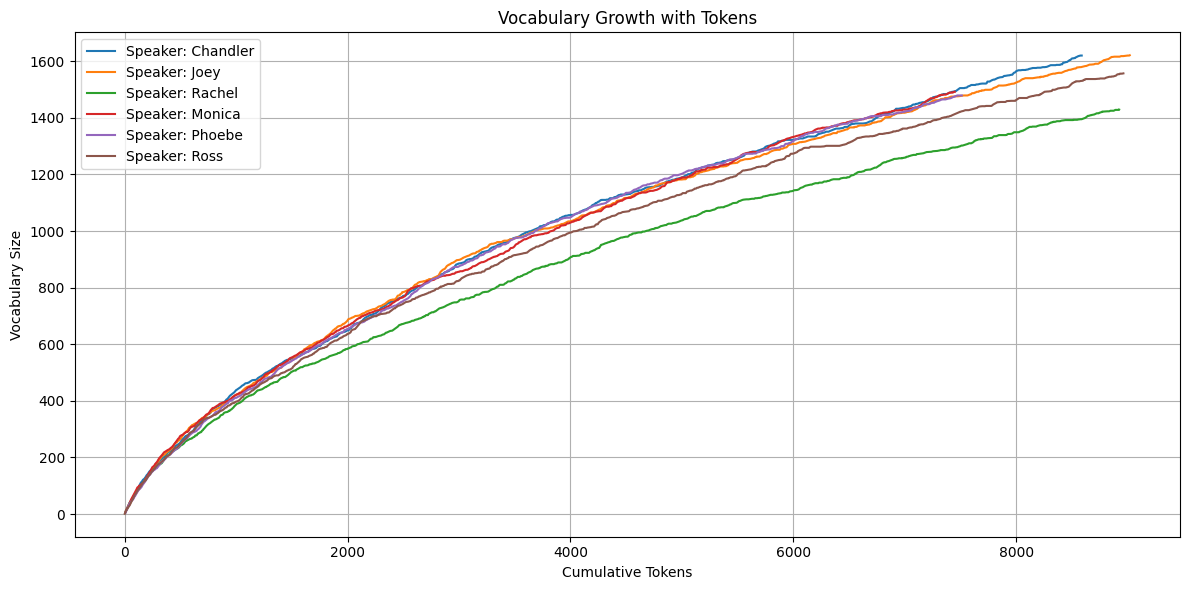

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split


# Function to calculate cumulative vocabulary growth with respect to tokens
def calculate_vocabulary_growth(speaker_df):
    cumulative_tokens = 0
    cumulative_vocabulary = set()
    vocabulary_growth = {'Tokens': [], 'Vocabulary': []}

    for _, row in speaker_df.iterrows():
        tokens = row['Tokens']
        cumulative_tokens += len(tokens)
        
        # Update vocabulary with new tokens
        cumulative_vocabulary.update(tokens)
        vocabulary_size = len(cumulative_vocabulary)

        # Append cumulative data
        vocabulary_growth['Tokens'].append(cumulative_tokens)
        vocabulary_growth['Vocabulary'].append(vocabulary_size)

    return pd.DataFrame(vocabulary_growth)

# Plot vocabulary growth for each speaker
plt.figure(figsize=(12, 6))
for speaker, speaker_df in speaker_dfs.items():
    vocab_growth_df = calculate_vocabulary_growth(speaker_df)
    plt.plot(vocab_growth_df['Tokens'], vocab_growth_df['Vocabulary'], label=f'Speaker: {speaker}')
    
plt.title(f'Vocabulary Growth with Tokens')
plt.xlabel('Cumulative Tokens')
plt.ylabel('Vocabulary Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Part 2: LDA Topic Modeling and Plotting

/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

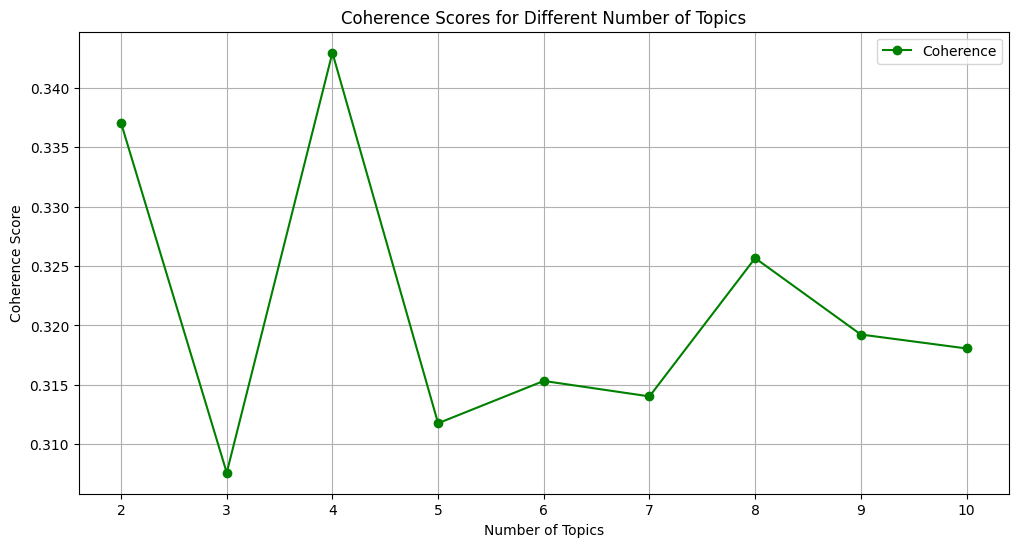

Optimal number of topics for Chandler: 4 with Coherence: 0.3429482316036089


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

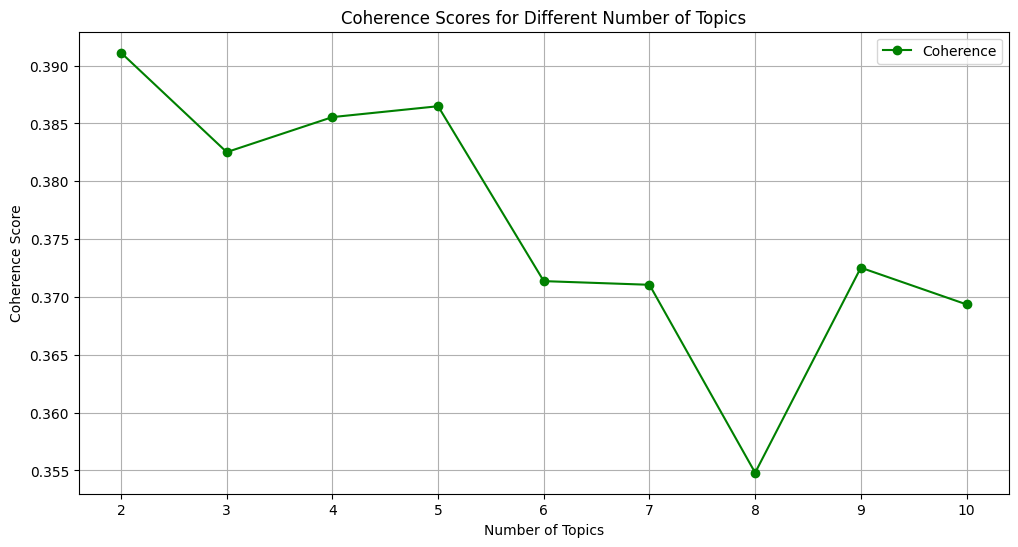

Optimal number of topics for Joey: 2 with Coherence: 0.3911188694196976


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

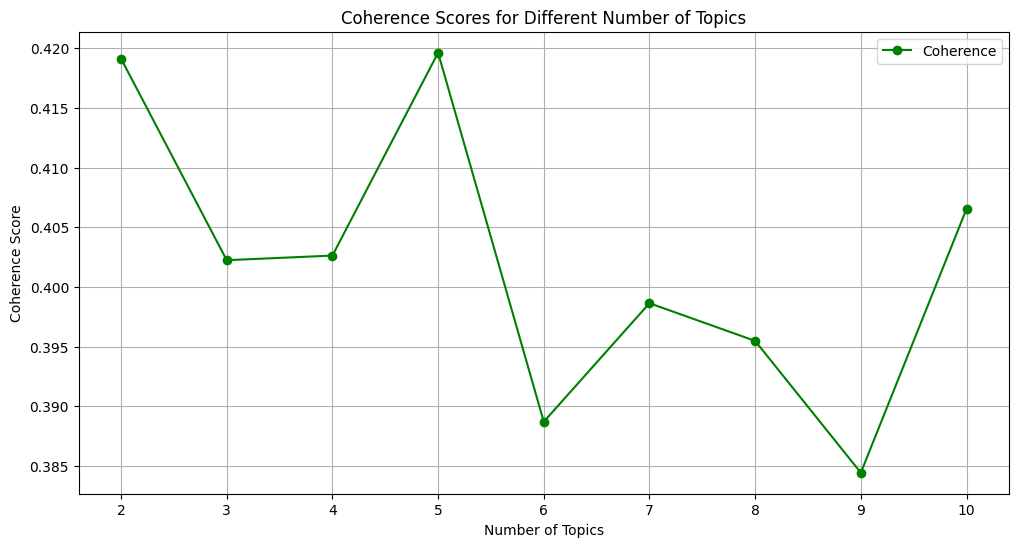

Optimal number of topics for Rachel: 5 with Coherence: 0.4196163300877644


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

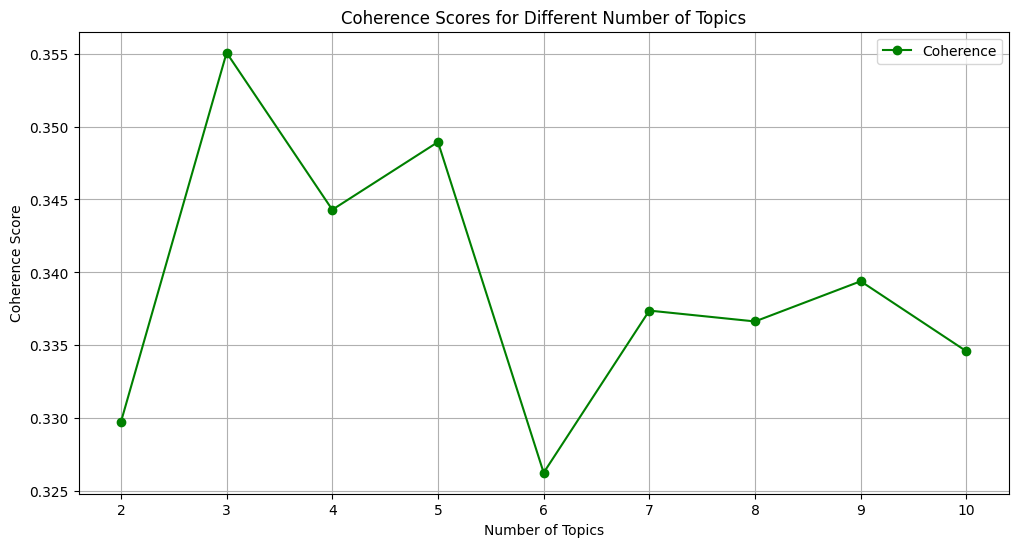

Optimal number of topics for Monica: 3 with Coherence: 0.3550623645062621


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

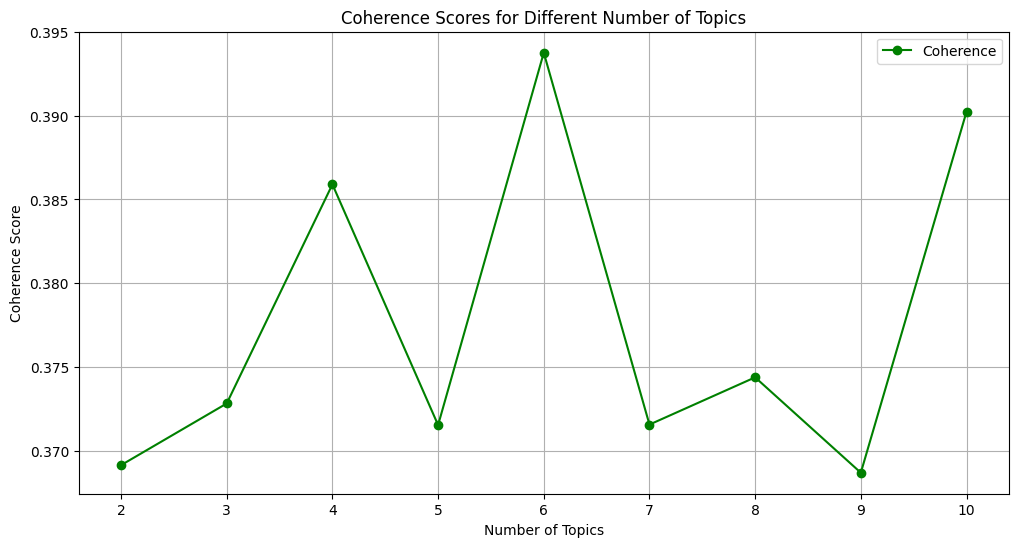

Optimal number of topics for Phoebe: 6 with Coherence: 0.39376387787833567


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

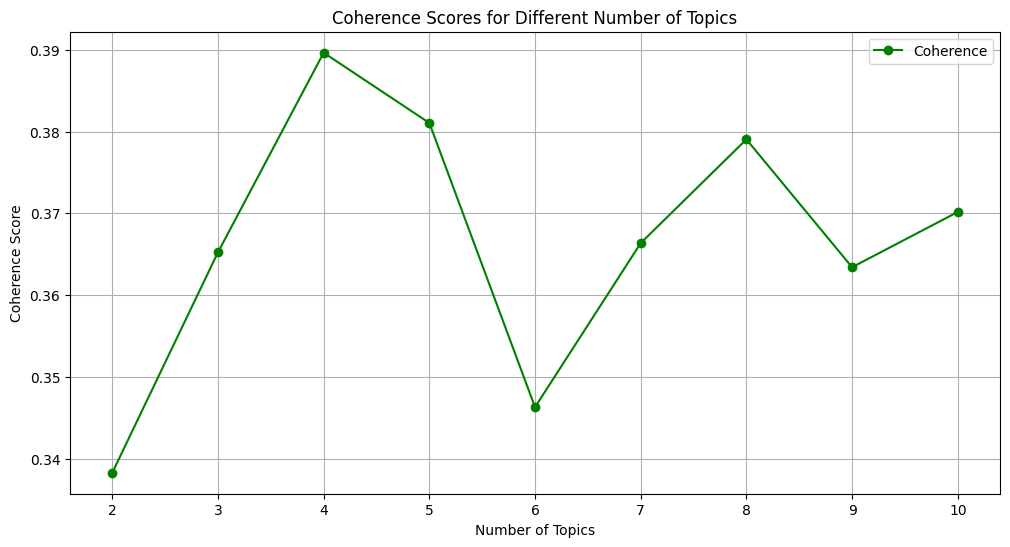

Optimal number of topics for Ross: 4 with Coherence: 0.38963988829352547


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

# Function to perform LDA topic modeling using gensim
def lda_topic_modeling(tokens_list, num_topics):
    # Create a dictionary and corpus for gensim
    dictionary = corpora.Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    
    # Create an LDA model
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Calculate coherence
    coherence_model = CoherenceModel(model=lda, texts=tokens_list, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()

    # Get topics
    topics = lda.print_topics(num_words=10)
    topics_dict = {f"Topic {i+1}": topic for i, topic in enumerate(topics)}

    return coherence, topics_dict

# Function to find the optimal number of topics
def find_optimal_topics(tokens_list, min_topics=2, max_topics=10):
    coherences = []

    for num_topics in range(min_topics, max_topics + 1):
        coherence, _ = lda_topic_modeling(tokens_list, num_topics)
        coherences.append(coherence)
    
    return coherences

def plot_metrics(coherences, topic_range):
    plt.figure(figsize=(12, 6))
    plt.plot(topic_range, coherences, marker='o', label='Coherence', color='g')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.title('Coherence Scores for Different Number of Topics')
    plt.legend()
    plt.grid()
    plt.show()

ans = []
# Applying LDA and plotting for each speaker
for speaker, speaker_df in speaker_dfs.items():
    tokens_list = speaker_df['Tokens']
    coherences = find_optimal_topics(tokens_list)

    topic_range = list(range(2, len(coherences) + 2))
    
    # Plot the results
    plot_metrics(coherences, topic_range)

    # Determine the best number of topics based on coherence
    best_index = np.argmax(coherences)
    print(f"Optimal number of topics for {speaker}: {topic_range[best_index]} with Coherence: {coherences[best_index]}")

    # Get topics for the best model
    best_num_topics = topic_range[best_index]
    _, best_topics = lda_topic_modeling(tokens_list, best_num_topics)
    ans.append(f"Best Topics for {speaker}: {best_topics}")


In [55]:
for speaker in ans:
    print(speaker)

Best Topics for Chandler: {'Topic 1': (0, '0.051*"i" + 0.024*"you" + 0.014*"that" + 0.013*"oh" + 0.013*"was" + 0.012*"of" + 0.012*"in" + 0.011*"with" + 0.011*"me" + 0.011*"what"'), 'Topic 2': (1, '0.058*"you" + 0.013*"in" + 0.012*"okay" + 0.012*"have" + 0.011*"like" + 0.011*"oh" + 0.010*"yeah" + 0.010*"well" + 0.010*"i" + 0.010*"just"'), 'Topic 3': (2, '0.065*"you" + 0.023*"what" + 0.022*"that" + 0.016*"i" + 0.014*"we" + 0.012*"so" + 0.011*"it" + 0.011*"me" + 0.009*"joey" + 0.009*"are"'), 'Topic 4': (3, '0.066*"i" + 0.020*"it" + 0.017*"you" + 0.017*"no" + 0.013*"hey" + 0.013*"this" + 0.011*"so" + 0.010*"what" + 0.010*"know" + 0.010*"oh"')}
Best Topics for Joey: {'Topic 1': (0, '0.050*"i" + 0.031*"you" + 0.018*"it" + 0.015*"that" + 0.011*"hey" + 0.011*"know" + 0.010*"what" + 0.009*"out" + 0.008*"me" + 0.008*"right"'), 'Topic 2': (1, '0.035*"you" + 0.035*"i" + 0.016*"it" + 0.015*"yeah" + 0.014*"oh" + 0.013*"hey" + 0.013*"that" + 0.012*"no" + 0.011*"what" + 0.010*"this"')}
Best Topics for

In [ ]:
nrc_lexicon = pd.read_csv("NRC_EmoLex_NRC-VAD-Lexicon.txt", sep='\t', header=None, names=['Word', 'Valence', 'Arousal', 'Dominance'])

results = {}

def calculate_vad_statistics(speaker_df):
    all_tokens = [token for tokens in speaker_df['Tokens'] for token in tokens]
    
    # Filter the NRC lexicon to get only the terms present in the speaker's tokens
    speaker_terms = nrc_lexicon[nrc_lexicon['Word'].isin(all_tokens)]
    
    if not speaker_terms.empty:
        results[speaker_df['Speaker'].iloc[0]] = {
            'Valence_Avg': speaker_terms['Valence'].mean(),
            'Arousal_Avg': speaker_terms['Arousal'].mean(),
            'Dominance_Avg': speaker_terms['Dominance'].mean(),
            'Valence_Std': speaker_terms['Valence'].std(),
            'Arousal_Std': speaker_terms['Arousal'].std(),
            'Dominance_Std': speaker_terms['Dominance'].std(),
            'Valence_Min': speaker_terms['Valence'].min(),
            'Arousal_Min': speaker_terms['Arousal'].min(),
            'Dominance_Min': speaker_terms['Dominance'].min(),
            'Valence_Max': speaker_terms['Valence'].max(),
            'Arousal_Max': speaker_terms['Arousal'].max(),
            'Dominance_Max': speaker_terms['Dominance'].max(),
            'Num_Lexicon_Terms': speaker_terms.shape[0]
        }


def calculate_emotion_patterns(speaker_df, nrc_vad_df):
    vad_scores = {'Valence': [], 'Arousal': [], 'Dominance': []}

    for tokens in speaker_df['Tokens']:
        for token in tokens:
            if token in nrc_vad_df.index:
                vad_scores['Valence'].append(nrc_vad_df.loc[token, 'Valence'])
                vad_scores['Arousal'].append(nrc_vad_df.loc[token, 'Arousal'])
                vad_scores['Dominance'].append(nrc_vad_df.loc[token, 'Dominance'])

    results = {
        'Valence': {
            'Mean': np.mean(vad_scores['Valence']),
            'Std': np.std(vad_scores['Valence']),
            'Min': np.min(vad_scores['Valence']),
            'Max': np.max(vad_scores['Valence'])
        },
        'Arousal': {
            'Mean': np.mean(vad_scores['Arousal']),
            'Std': np.std(vad_scores['Arousal']),
            'Min': np.min(vad_scores['Arousal']),
            'Max': np.max(vad_scores['Arousal'])
        },
        'Dominance': {
            'Mean': np.mean(vad_scores['Dominance']),
            'Std': np.std(vad_scores['Dominance']),
            'Min': np.min(vad_scores['Dominance']),
            'Max': np.max(vad_scores['Dominance'])
        }
    }

    return results


for speaker, speaker_df in speaker_dfs.items():
    speaker_df['Speaker'] = speaker  # Add a speaker column for reference
    calculate_vad_statistics(speaker_df)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
results_df

In [ ]:
# Insights on personality traits based on VAD scores
for speaker in results_df.index:
    valence = results_df.loc[speaker, 'Valence_Avg']
    arousal = results_df.loc[speaker, 'Arousal_Avg']
    dominance = results_df.loc[speaker, 'Dominance_Avg']
    
    # Example of commenting
    if valence < 0.5 and arousal < 0.45:
        print(f"{speaker} tends to exhibit negative emotions and low energy, possibly indicating traits like introversion.")
    elif valence > 0.5 and arousal > 0.45:
        print(f"{speaker} tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.")
